<a href="https://colab.research.google.com/github/clachevv/neuro-match-project/blob/main/notebooks/380_fmri_loaded_from_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Installations
%%capture

!pip install nilearn
!pip install decord

In [2]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
import pandas as pd
# from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
  fmri_dir = './participants_data_v2021'
  track = "full_track"
  results_dir = '/content/'
  track_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(track_dir, sub)
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB")
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

In [5]:
#@title Loading fMRI data and inspecting dimensions
# sub = 'sub01'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]

# ROI = 'WB'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

# ######## fMRI data loader wrapper code ###################################
# fmri_dir = '/content/drive/MyDrive/neuromatch/participants_data_v2021'
# if ROI == "WB":
#     track = "full_track"
# else:
#     track = "mini_track"
# results_dir = '/content/'
# track_dir = os.path.join(fmri_dir, track)
# sub_fmri_dir = os.path.join(track_dir, sub)
# if track == "full_track":
#     fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
# else:
#     fmri_train_all = get_fmri(sub_fmri_dir,ROI)

######## fMRI data loader wrapper code ###################################


# f, ax = plt.subplots(figsize=(12, 5))
# ax.set(xlabel="Voxel", ylabel="Stimulus")
# heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
# f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
# f.tight_layout()

fMRI_RDMs is a dictionary with keys `'EVC_RDMs'` and `'IT_RDMs'` corresponding to ROIs EVC and IT respectively. The shape of each RDM is `num_subjects` $\times$ `num_stimulus` $\times$ `num_stimulus`.

- dict - 9 ROIs
- dict[ROI] = 10 x 1000 x 1000

In [6]:
subjects = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
ROIs = ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
fmri_dir = '/content/drive/MyDrive/neuromatch/participants_data_v2021'
track_dir = os.path.join(fmri_dir, "mini_track")

fmri_results = {}
for sub in subjects:
  all_brain_scan = {}
  for ROI in ROIs:
    sub_fmri_dir = os.path.join(track_dir, sub)
    all_brain_scan[ROI]=get_fmri(sub_fmri_dir, ROI)
  fmri_results[sub]=all_brain_scan

In [7]:
# this loads result from AlexNet Classification (with LLM reduction)
classes = pd.read_csv('/content/drive/MyDrive/neuromatch/NEW 380 video cats.csv', header=0)
classes['video_path'] = classes['video_id']
classes['video_id'] = classes['video_id'].str.split("/").str.get(3)
classes = classes[classes['index'] <= 1000]
classes['act_index'] = classes['index'] + 1
dicty = classes[['act_index','llm_classes']]

In [8]:
filtered_activity = {}
for sub, ROIs in fmri_results.items():
    for ROI,data in ROIs.items():
        brain = pd.DataFrame(data).reset_index()
        brain['index'] = brain['index']+1
        brain.columns = ['act_' + str(item) for item in brain.columns]
        filtered_brain = brain.merge(dicty, on = 'act_index', how='right')
        filtered_activity[f'{sub}_{ROI}'] = filtered_brain

In [9]:
maping_video_classes = dict(zip(dicty.index, dicty['llm_classes']))

replacements = {
    'Natural Phenomena and Places':'Natural\nPhenomena\nand Places',
    'Objects and Tools':'Objects\nand\nTools',
    'Sports and Recreation':'Sports\nand\nRecreation'
}

for key, value in maping_video_classes.items():
    if value in replacements:
        maping_video_classes[key] = replacements[value]

In [10]:
# Calculate class boundaries for annotation
stimuli_classes = list(maping_video_classes.values())
unique_classes = set(stimuli_classes)
class_indices = {cls: [] for cls in unique_classes}
for idx, cls in enumerate(stimuli_classes):
    class_indices[cls].append(idx)

end_indices = [indices[-1] + 0.5 for indices in class_indices.values()]
end_indices.sort()

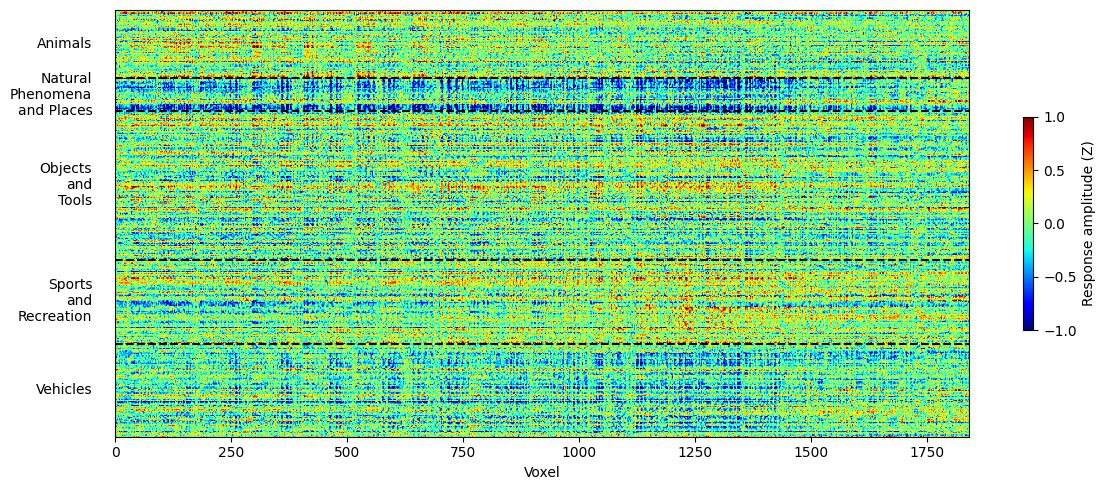

In [11]:
f, ax = plt.subplots(figsize=(12, 5))

ax.set(xlabel="Voxel", ylabel="Stimulus")
plot_array = filtered_activity['sub01_LOC'].drop(columns=['act_index','llm_classes']).to_numpy()
heatmap = ax.imshow(plot_array, aspect="auto",cmap='jet',vmin=-1,vmax=1)


for end in end_indices[:-1]:
    plt.axhline(y=end, color='black', linestyle='--', linewidth=1.5)

for cls, indices in class_indices.items():
    middle = int(np.mean(indices))
    ax.text(-50, middle, cls, fontsize=10, color='black', rotation=0,
                verticalalignment='center', horizontalalignment='right')


plt.ylabel('')
plt.yticks([])
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()


In [12]:
[54, 81, 201, 269, 344]

[54, 81, 201, 269, 344]

In [13]:
model_RDMs = {}

for sub_roi, fmri in filtered_activity.items():
    plot_array = fmri.drop(columns=['act_index','llm_classes']).to_numpy()
    model_RDMs[sub_roi] = 1- np.corrcoef(plot_array)

In [14]:
final_df = pd.DataFrame()
for sub_ROI, weights in model_RDMs.items():
    df = pd.DataFrame(weights)
    df.columns = ["video_"+str(col) for col in df.columns]
    df['sub_ROI'] = sub_ROI
    df = df.reset_index()
    df['index'] =  "video_" + df['index'].astype(str)
    final_df = pd.concat([final_df,df])

final_df.to_csv("/content/drive/MyDrive/neuromatch/results/rdm_values_fmri380.csv",index=False)

In [16]:
sub08 = final_df[final_df.sub_ROI.str.contains("sub08")]
sub08['roi']=sub08.sub_ROI.str.split("_").str.get(1)

<ipython-input-16-f5434c8d670a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub08['roi']=sub08.sub_ROI.str.split("_").str.get(1)


Text(0.5, 1.05, 'sub08 stimuli RDMs')

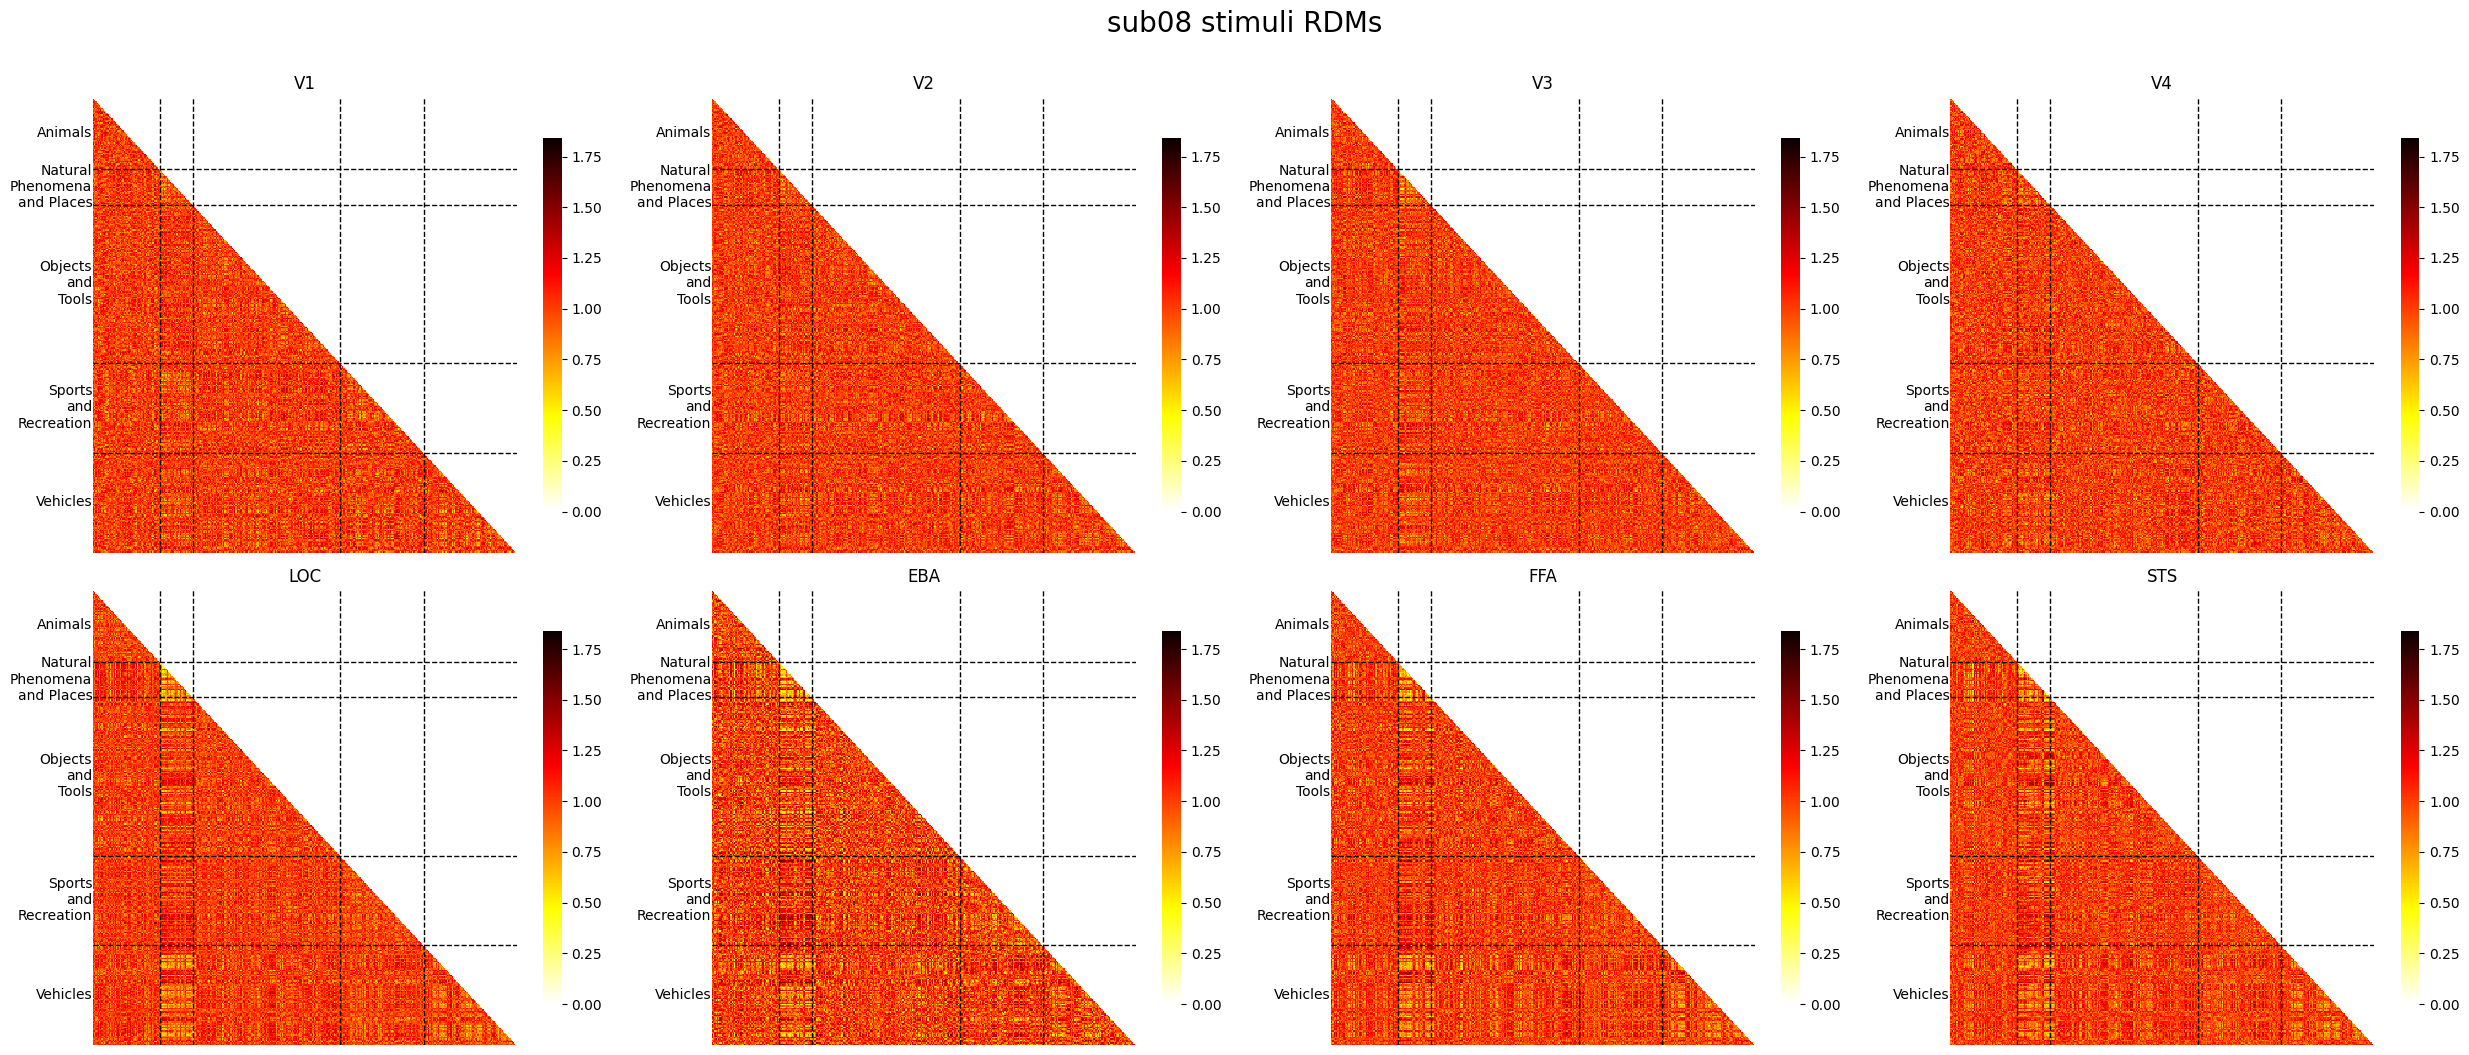

In [19]:
def create_rdm_plot(roi,ax):
    rdm = sub08[sub08.roi == roi].drop(columns=['index','sub_ROI','roi']).to_numpy()
    mask = np.triu(np.ones_like(rdm, dtype=bool))

    # Create the heatmap
    vmin=0 ;vmax=1.84
    sns.heatmap(rdm, mask=mask, cmap='hot_r',vmin=vmin, vmax=vmax, square=False, cbar_kws={"shrink": .82}, ax=ax)

    # Calculate class boundaries for annotation
    for end in end_indices[:-1]:  # Exclude the last boundary to avoid drawing a line after the last class
        ax.axvline(x=end, color='black', linestyle='--', linewidth=1)
        ax.axhline(y=end, color='black', linestyle='--', linewidth=1)

    # Annotate the x-axis with a single label at the center of each class
    for cls, indices in class_indices.items():
        middle = int(np.mean(indices))
        ax.text(-0.5, middle, cls, ha='right', va='center', fontsize=10, color='black', rotation=0, transform=ax.transData)

    ax.set_title(f"{roi}")
    ax.set_xticks([])
    ax.set_yticks([])
    # plt.show()

fig, axes = plt.subplots(2,4, figsize=(25,10))
axes = axes.flatten()
for ax,roi in zip(axes,sub08.roi.unique()):
    create_rdm_plot(roi,ax)

plt.tight_layout()
fig.suptitle('sub08 stimuli RDMs', fontsize=20, y=1.05)

In [ ]:
# average of the RDMs (under construction)

In [24]:
sub08_dict = {}
for name, group in sub08.groupby("roi"):
    sub08_dict[name]=group.drop(columns=['index','sub_ROI','roi']).to_numpy()

classes_and_end_index_dict = {
    'Animals': 54,
    'Natural Phenomena and Places': 81,
    'Objects and Tools': 201,
    'Sports and Recreation': 269,
    'Vehicles': 344
}

In [27]:
new_rdm_dict = {}
for roi, rdm in sub08_dict.items():
    # Initialize a new RDM matrix for the averaged result
    new_rdm = np.zeros((5, 5))

    # Get the indices for each class
    class_indices = list(classes_and_end_index_dict.values())
    class_indices = [0] + class_indices

    for i, class_name in enumerate(classes_and_end_index_dict.keys()):
        start_index = class_indices[i]
        end_index = class_indices[i + 1]

        # Extract the submatrix for the current class
        submatrix = rdm[start_index:end_index+1, start_index:end_index+1]

        # Compute the average within the submatrix
        class_avg = np.mean(submatrix, axis=(0, 1))

        # Update the new RDM matrix
        new_rdm[i, i] = class_avg

    # Store the new RDM matrix in the output dictionary
    new_rdm_dict[roi] = new_rdm


In [32]:
# Initialize the output dictionary for new RDMs
new_rdm_dict = {}

# Compute the average RDM for each class
for roi, rdm in sub08_dict.items():
    # Initialize a new RDM matrix for the averaged result
    new_rdm = np.zeros((5, 5))

    # Get the start and end indices for each class
    class_names = list(classes_and_end_index_dict.keys())
    class_indices = list(classes_and_end_index_dict.values())
    class_indices = [0] + class_indices  # Include the start index for the first class

    # Compute average dissimilarity between pairs of classes
    for i, class_name_i in enumerate(class_names):
        start_index_i = class_indices[i]
        end_index_i = class_indices[i + 1]

        for j, class_name_j in enumerate(class_names):
            start_index_j = class_indices[j]
            end_index_j = class_indices[j + 1]

            # Extract submatrices for the two classes
            submatrix_i = rdm[start_index_i:end_index_i+1, start_index_i:end_index_i+1]
            submatrix_j = rdm[start_index_j:end_index_j+1, start_index_j:end_index_j+1]

            # Compute average dissimilarity between the two classes
            avg_dissimilarity = np.mean(submatrix_i + submatrix_j) / 2.0

            # Update the new RDM matrix
            new_rdm[i, j] = avg_dissimilarity

    # Store the new RDM matrix in the output dictionary
    new_rdm_dict[roi] = new_rdm

# Output the new RDMs
for roi, avg_rdm in new_rdm_dict.items():
    print(f'{roi} Average RDM:\n{avg_rdm}\n')

ValueError: operands could not be broadcast together with shapes (55,55) (28,28) 

In [ ]:
# clustering (under construction)

In [ ]:
filtered_activity['sub01_LOC'].drop(columns=['act_index','llm_classes']).T.to_csv("fmri380.csv",index=False)

In [ ]:
sub_loc = [key for key in filtered_activity.keys() if "LOC" in key]
n_components = 100
seed=42

train_out, test_out = {},{}
for sub in sub_loc[:1]:#tqdm(sub_loc):
    data = filtered_activity['sub01_LOC']
    numpyarray = data.drop(columns=['act_index','llm_classes']).to_numpy()
    x_train = numpyarray[:70,:]
    x_test = numpyarray[4:,:]


    start_time = time.time()
    x_test = StandardScaler().fit_transform(x_test)
    x_train = StandardScaler().fit_transform(x_train)
    ipca = PCA(random_state=seed, n_components=48)
    ipca.fit(x_train)

    explained_variance = ipca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance.cumsum()

    train = ipca.transform(x_train)
    test = ipca.transform(x_test)
    train_out[sub]=train
    test_out[sub]=test